# Basic Imports

In [5]:
import numpy as пр
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_roc_curve, accuracy_score

In [6]:
data = pd.read_excel('/content/obscured_slate_applicant_data.xlsx')
data.drop(["term","efc","prospect_date","inquiry_date","start_date","submit_date","admit_date","confirm_date","withdraw_date","event_date","individual_visit","in_county","miles","has_fafsa","acs_pct_graduate","acs_pct_bachelors","acs_inc_per_capita","acs_pct_100t150","acs_pct_150t200","acs_pct_200p","gpa_recalc","application_slate_id","id"], axis = 1,inplace = True)
data.head()

,enroll,sex,in_state,dept,honors_invite,acs_median_income,test_optional,gpa_reader,common_app,commuter,catholic,first_source
0,0,M,0,major4,0,81101.0,0,3.07,1,0,0,Test Scores Received
1,1,M,1,major8,1,46304.0,0,3.98,1,0,0,High School Visit
2,0,F,0,major4,0,68806.0,0,3.04,1,0,0,College Board Search Service
3,0,F,0,major7,0,38969.0,1,3.16,1,0,0,Started an MU Application
4,0,F,1,major2,0,42794.0,0,3.27,1,0,0,Raise.me Follower


#Shape and information regarding the data

In [7]:
data.shape

(6340, 12)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6340 entries, 0 to 6339
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   enroll             6340 non-null   int64  
 1   sex                6337 non-null   object 
 2   in_state           6340 non-null   int64  
 3   dept               6340 non-null   object 
 4   honors_invite      6340 non-null   int64  
 5   acs_median_income  6305 non-null   float64
 6   test_optional      6340 non-null   int64  
 7   gpa_reader         4668 non-null   float64
 8   common_app         6340 non-null   int64  
 9   commuter           6340 non-null   int64  
 10  catholic           6340 non-null   int64  
 11  first_source       6340 non-null   object 
dtypes: float64(2), int64(7), object(3)
memory usage: 594.5+ KB


#Columns description

In [9]:
print(data.columns)
print(len(data.columns))

Index(['enroll', 'sex', 'in_state', 'dept', 'honors_invite',
       'acs_median_income', 'test_optional', 'gpa_reader', 'common_app',
       'commuter', 'catholic', 'first_source'],
      dtype='object')
12


#unique values

In [10]:
data.nunique()

enroll                  2
sex                     2
in_state                2
dept                   25
honors_invite           2
acs_median_income    1980
test_optional           2
gpa_reader            237
common_app              2
commuter                2
catholic                2
first_source           26
dtype: int64

#duplicates

In [11]:
data.duplicated().any()

True

# Missing Values in remaining columns of the dataset and the percentages to fill

In [12]:
missing_data =data.isnull().sum(axis=0).reset_index()
missing_data.columns = ['Column Name', 'Count of missing values']
missing_data['Filled Level (%)']=(data.shape[0]-missing_data['Count of missing values'])/data.shape[0]*100
missing_data.sort_values('Filled Level (%)').reset_index(drop = True)

,Column Name,Count of missing values,Filled Level (%)
0,gpa_reader,1672,73.627760
1,acs_median_income,35,99.447950
2,sex,3,99.952681
3,enroll,0,100.000000
4,in_state,0,100.000000
5,dept,0,100.000000
6,honors_invite,0,100.000000
7,test_optional,0,100.000000
8,common_app,0,100.000000
9,commuter,0,100.000000


#Univariate Analysis

In [13]:
def plotter(df=data,col_name='enroll'):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,4))
    ax = sns.countplot(x=col_name, data=df)
    plt.title(f"Distribution of  {' '.join(col_name.split('_'))}")
    plt.xlabel(f"Number of  {' '.join(col_name.split('_'))}")
    plt.xticks(rotation=45)
    total = len(data[col_name])
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        percentage = f'{100 * p.get_height()/total:.1f}%'
        x, y = p.get_xy() 
        ax.annotate(percentage, (x + width/2, y + height*1.02), ha='center')


    return plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

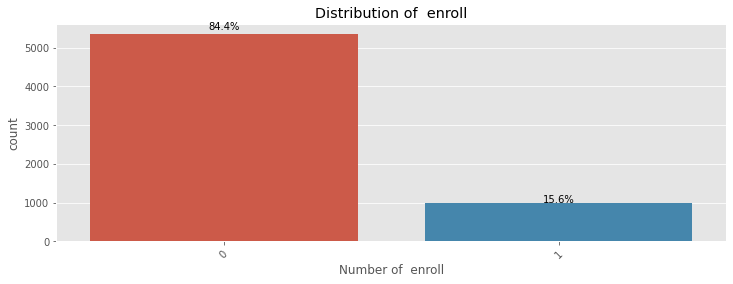

  8%|▊         | 1/12 [00:00<00:01,  6.40it/s]

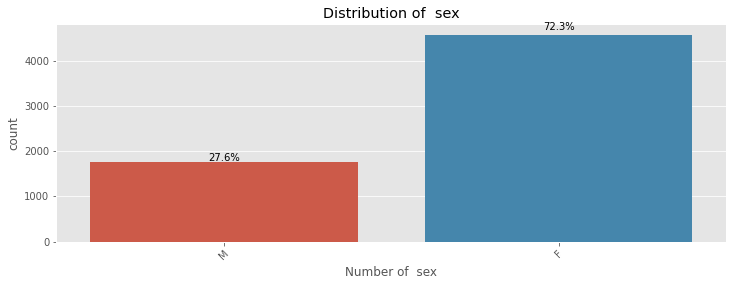

 17%|█▋        | 2/12 [00:00<00:01,  6.37it/s]

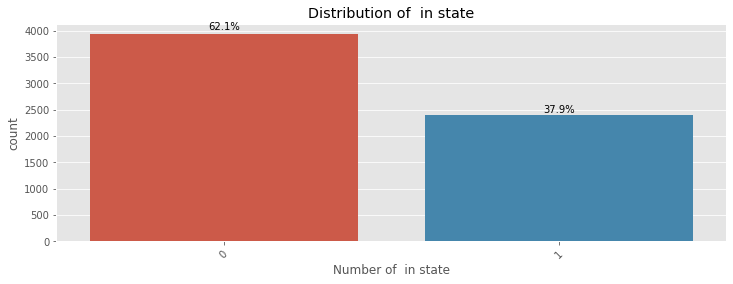

 25%|██▌       | 3/12 [00:00<00:01,  6.52it/s]

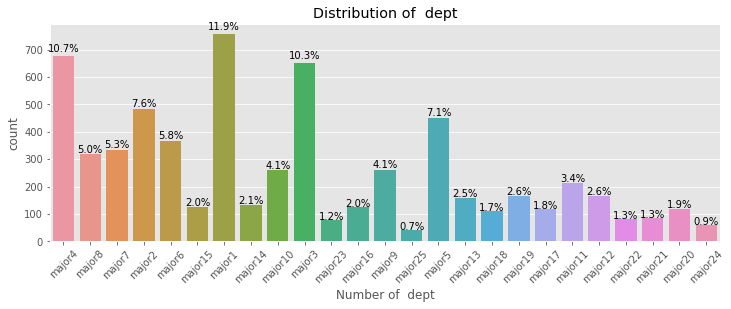

 33%|███▎      | 4/12 [00:00<00:01,  4.37it/s]

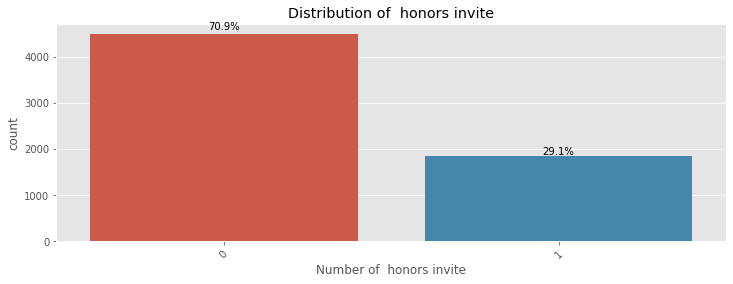

 42%|████▏     | 5/12 [00:01<00:01,  4.88it/s]

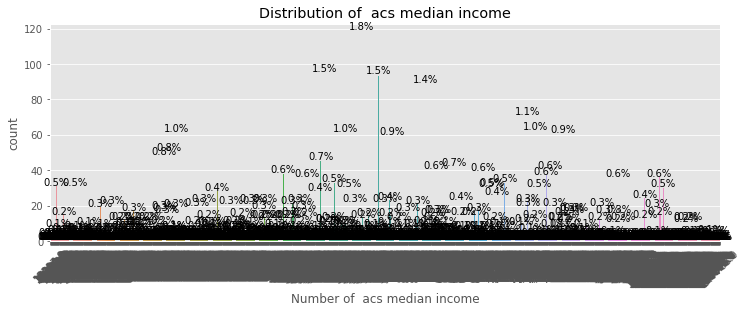

 50%|█████     | 6/12 [00:28<00:50,  8.50s/it]

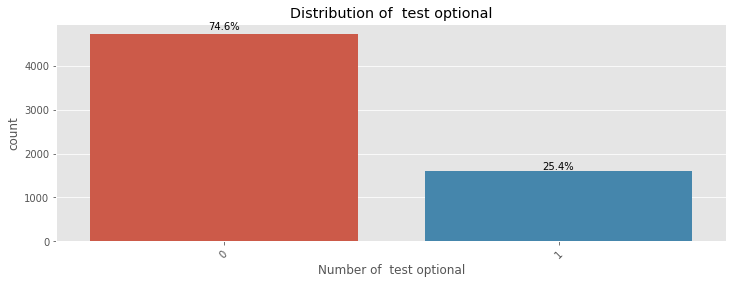

 58%|█████▊    | 7/12 [00:29<00:29,  6.00s/it]

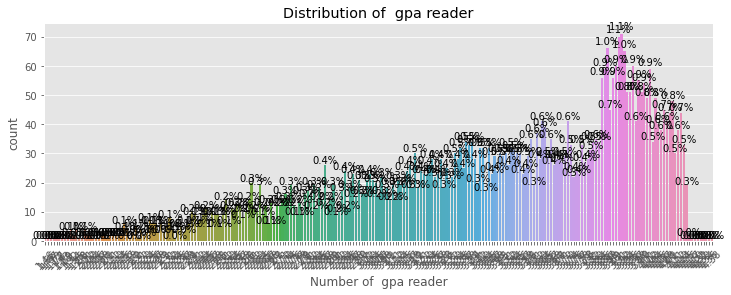

 67%|██████▋   | 8/12 [00:32<00:21,  5.26s/it]

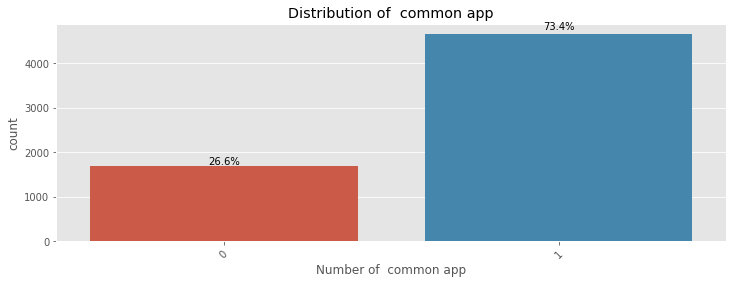

 75%|███████▌  | 9/12 [00:32<00:11,  3.73s/it]

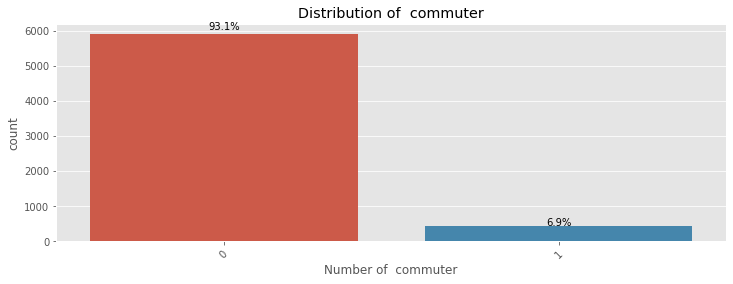

 83%|████████▎ | 10/12 [00:32<00:05,  2.65s/it]

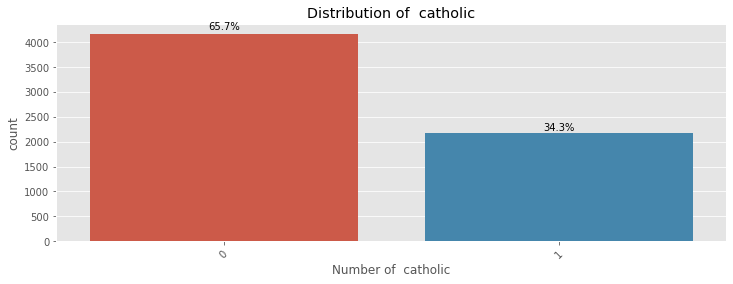

 92%|█████████▏| 11/12 [00:33<00:01,  1.90s/it]

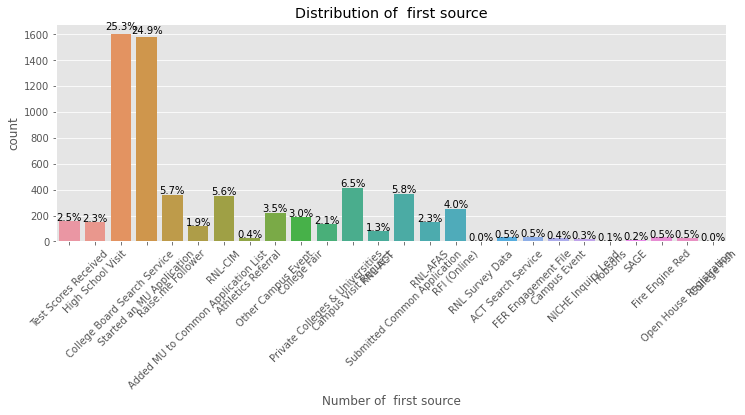

100%|██████████| 12/12 [00:33<00:00,  2.79s/it]


In [14]:
for col in tqdm(list(data.columns)):
    # if (data[col].dtype=='object'):
    plotter(col_name=col)

# Model Selection 

In [15]:
data1 = pd.read_excel('/content/obscured_slate_applicant_data.xlsx')
data1.drop(["term","efc","prospect_date","test_optional","in_county","sex","dept","acs_median_income","gpa_reader","first_source","inquiry_date","start_date","submit_date","admit_date","confirm_date","withdraw_date","event_date","individual_visit","miles","has_fafsa","acs_pct_graduate","acs_pct_bachelors","acs_inc_per_capita","acs_pct_100t150","acs_pct_150t200","acs_pct_200p","gpa_recalc","application_slate_id","id"], axis = 1,inplace = True)
data1.head()

,enroll,in_state,honors_invite,common_app,commuter,catholic
0,0,0,0,1,0,0
1,1,1,1,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,1,0,1,0,0


In [16]:
# Features
target = "enroll"
X = data1.drop(columns=target)
y = data1[target]

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=47)

In [18]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((5072, 5), (1268, 5), (5072,), (1268,))

# Feature selection using Mutual Information

In [19]:
# get number of most relevant features
threshold= 5 
high_score_ft = []
feature_scores = mutual_info_classif(X,y, random_state=47)


In [20]:
for score, f_name  in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
    print(f_name, score)
    high_score_ft.append(f_name)


common_app 0.02697710348475768
in_state 0.012994907621386886
commuter 0.012955605238107237
catholic 0.005745295403452255
honors_invite 0.00040447392283082806


In [21]:
feature_set = list(set(high_score_ft))

# Building a Logistic Regression Classifier

The accuracy using Logistic Regression is:83.75394321766562%
Classification Report
              precision    recall  f1-score   support

         Yes       0.84      0.99      0.91      1064
          No       0.44      0.04      0.07       204

    accuracy                           0.84      1268
   macro avg       0.64      0.51      0.49      1268
weighted avg       0.78      0.84      0.78      1268



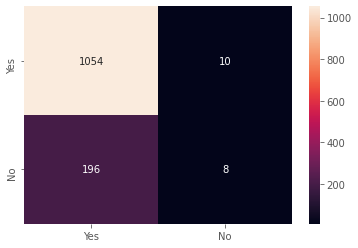

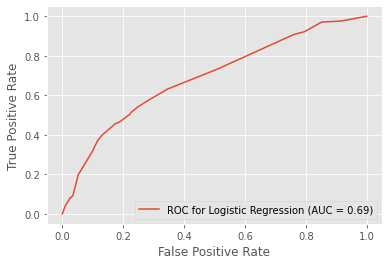

In [22]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(xtrain[feature_set], ytrain) 
y_pred = pipe.predict(xtest[feature_set])
print(f'The accuracy using Logistic Regression is:{(accuracy_score(ytest, y_pred))*100}%')
cm = confusion_matrix(ytest, y_pred)
print('Classification Report')
print(classification_report(ytest, y_pred,target_names=
                                ['Yes','No']))
sns.heatmap(cm, annot=True, yticklabels=['Yes','No'],xticklabels=['Yes','No'],fmt='d');
plot_roc_curve(pipe,xtest[feature_set], ytest, name='ROC for Logistic Regression');
